In [13]:
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from corextopic import corextopic as ct
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import re

df_t = pd.read_csv('QandA.csv')
stop_words = stopwords.words('english')
stop_words.extend(['hello', 'hi', 'welcom', 'headout', 'know', 'experi', 'refer', 'help', 'ani', 'chat', 'problem', 'may', 'reach', 'need', 'let', 'u', 'feel', 'free', 'contact', 'realli', 'appreci', 'could', 'rate', 'chat', 'thank', 'today', 'wa', 'nice', 'talk', 'great', 'day', 'goodby', 'would', 'like','plea', 'wait', 'minut', 'check', 'thi', 'anyth', 'el', 'step', 'away', 'assist', 'custom', 'bye', 'hey', 'ok','get', 'ye', 'safari', 'khalifa', 'burj', 'aquarium', 'roman', 'palatin', 'vatican', 'dubai'])


class preprocess(object):
    '''
    Preprocessing text for classifier
    
    Parameters
    ----------
    text: text to be processed
    stop_words: list of stop_words from nltk
    '''
    def __init__(self, text):
        self.text = text
        
    def tokenizer(self):
        return RegexpTokenizer(r'\w+').tokenize(self.text.lower())
    
    def stem_words(self):
        '''
        Stem words

        Input:
        -----------------------
        List of words

        Return:
        ------------------------
        List of stemmed words
        '''
        porter_stemmer = PorterStemmer()
        return [porter_stemmer.stem(words) for words in self.tokenizer()]
    
    def lemmatize_words(self):
        '''
        Lemmatize words

        Input:
        -----------------------
        List of words

        Return:
        ------------------------
        List of lemmatized words
        '''
        wordnet_lemmatizer = WordNetLemmatizer()
        return [wordnet_lemmatizer.lemmatize(words) for words in self.stem_words()]

    def prep(self, stop_words):
        '''
        Remove stop words

        Input:
        -----------------------
        List of words

        Return:
        ------------------------
        List of words with stop words removed
        '''
        return [word for word in self.lemmatize_words() if word not in stop_words]
    
# Preprocess transcripts
df_l = df_t.QandA.apply(lambda s: ' '.join(preprocess(s).prep(stop_words)))

cv = CountVectorizer(stop_words='english', max_features=20000, binary=True)
c = cv.fit_transform(df_l)

words = list(np.asarray(cv.get_feature_names()))

# Anchor words
anchor_words = [['cashback', 'cash'], 
                ['refund', 'cancel'], 
                ['child', 'adult','year','old','age','kid'], 
                ['seat', 'choos','select','section','offic','exact','togeth'],
                ['discount','coupon','code','use'],
                ['card','payment','work','complet','error','issu','differ','tri']
               ]


topic_model = ct.Corex(n_hidden=25, max_iter=200, seed=1)
topic_model.fit(c, words=words, anchors=anchor_words, anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cashback,cash,wallet,log,facebook,futur,creat,virtual,user,di
1: cancel,refund,polici,reschedul,strict,amend,money,85640771,8885223,48
2: adult,child,year,old,age,kid,abov,yr,18,daughter
3: seat,select,choos,offic,section,exact,togeth,box,best,intellig
4: use,discount,code,coupon,promo,browser,app,wow,alreadi,love
5: tri,card,differ,work,issu,payment,complet,error,credit,chrome
6: floor,parti,3rd,2nd,partner,vendor,local,question,wish,divid
7: hotel,pick,drop,park,zoo,transfer,pickup,water,singapor,ride
8: ticket,buy,book,purchas,want,onlin,websit,make,price,onli
9: cruis,pari,versail,franc,sein,palac,dhow,garden,river,bateaux
10: guid,tour,colosseum,access,museum,chapel,sistin,forum,audio,includ
11: time,pm,hour,30,00,10,start,slot,11,12
12: charg,fee,currenc,tax,conveni,usd,convers,dollar,ad,inr
13: request,kindli,fulfil,someth,idea,citizen,whi,wrong,went,sound
14: begin,admiss,mt,end,90,told,length,19,wit,therefor
15: line,skip,tower,eiffel,abu,summit,dhabi,entri,climb,louvr
16: 

# Topic Correlation Distribution

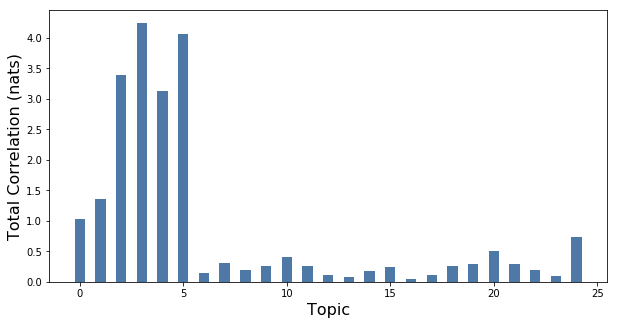

In [14]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## Pointwise total correlation distribution

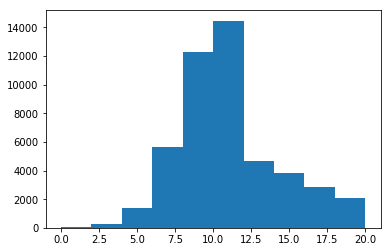

In [15]:
plt.hist(topic_model.log_z.sum(1), range=[0,20])
plt.show()

In [16]:
# Documents topic dataframe
df_top = pd.DataFrame(columns = ['logsum','topic','PTC'])
TC = topic_model.log_z
df_top['logsum'] = TC.sum(1)
df_top['topic'] = TC.argmax(1)
# Calculate Pointwise TC for each document
doc_cor = []
for i,row in df_top.iterrows():
    doc_cor.append(TC[i,int(row.topic)])
df_top['PTC'] = doc_cor
df_top.head()

,logsum,topic,PTC
0,71.080137,0,45.898451
1,40.540484,0,26.868874
2,4.920945,5,1.837017
3,13.618236,20,5.829310
4,14.667880,20,5.702902


In [18]:
# Percentage of each topic
ntopic=25
df_perc = pd.DataFrame(columns=['topic_no','percentage','keywords'])
df_perc['topic_no'] = list(i for i in range(ntopic))
rowN = float(df_top.shape[0])
for i in range(ntopic):
#     Calculate percentage
    df_perc.at[i,'percentage'] = df_top.loc[(df_top.topic == i) & (df_top.PTC > 8)].shape[0]/rowN
#     Key words
    topic_words,_ = zip(*topics[i])
    df_perc.at[i,'keywords'] = ' ,'.join(topic_words)
    
df_perc.head(7)

,topic_no,percentage,keywords
0,0,0.0159716,"cashback ,cash ,wallet ,log ,facebook ,futur ,..."
1,1,0.0266092,"cancel ,refund ,polici ,reschedul ,strict ,ame..."
2,2,0.0455122,"adult ,child ,year ,old ,age ,kid ,abov ,yr ,1..."
3,3,0.0504533,"seat ,select ,choos ,offic ,section ,exact ,to..."
4,4,0.0603657,"use ,discount ,code ,coupon ,promo ,browser ,a..."
5,5,0.0448625,"tri ,card ,differ ,work ,issu ,payment ,comple..."
6,6,0.00134482,"floor ,parti ,3rd ,2nd ,partner ,vendor ,local..."


# Word Cloud

In [19]:
from scipy.optimize import curve_fit
from wordcloud import WordCloud

## Refund

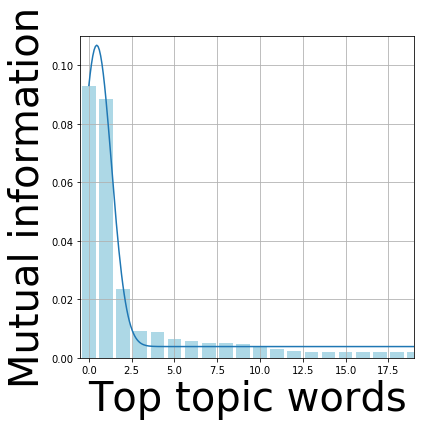

In [20]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=1, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, x0, sigma, offset:  offset+A*np.exp(-((x-x0)/sigma)**2)
popt, pcov = curve_fit(fit, x, proba, p0=[1,0,1,0])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.11])
plt.tight_layout()
plt.show()

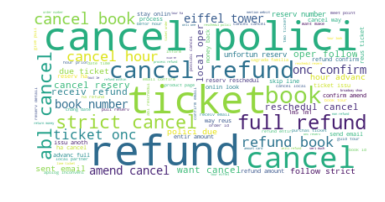

In [21]:
# Word cloud
text = ' '.join(df_l.loc[(df_top.topic == 1) & (df_top.PTC > 8)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Kids

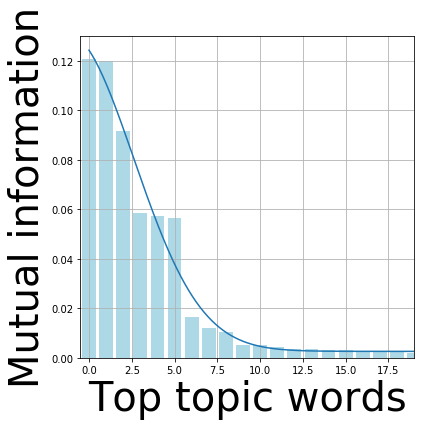

In [22]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=2, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, x0, sigma, offset:  offset+A*np.exp(-((x-x0)/sigma)**2)
popt, pcov = curve_fit(fit, x, proba, p0=[1,0,1,0])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.13])
plt.tight_layout()
plt.show()

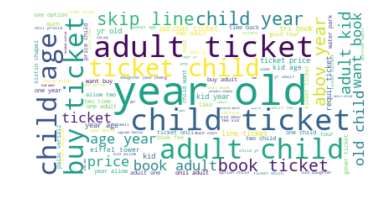

In [23]:
# Word cloud
text = ' '.join(df_l.loc[(df_top.topic == 2) & (df_top.PTC > 8)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Selecting seats

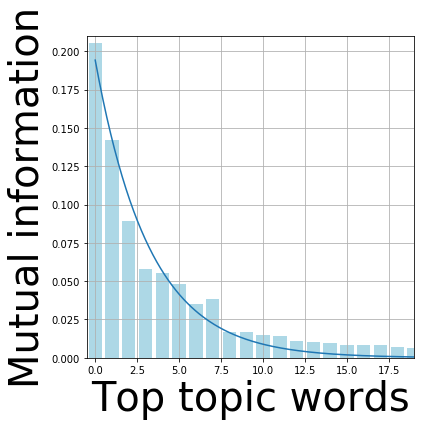

In [24]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=3, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, sigma:  A*np.exp(-(x/sigma))
popt, pcov = curve_fit(fit, x, proba, p0=[.2,10])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.21])
plt.tight_layout()
plt.show()

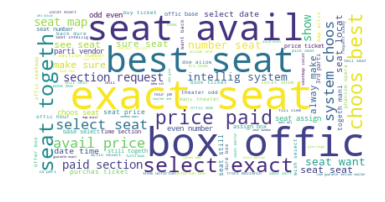

In [26]:
# Word cloud
text = ' '.join(df_l.loc[(df_top.topic == 3) & (df_top.PTC > 8)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Discount

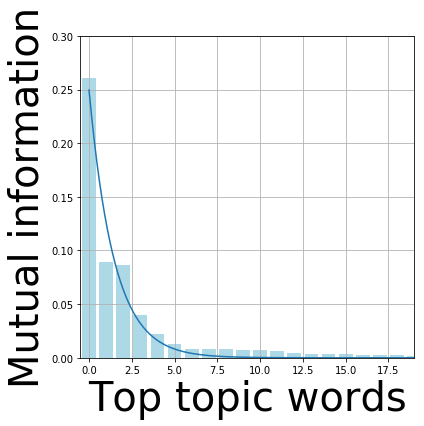

In [34]:
# Mutual information
nwords = 20
topic_words, proba = zip(*topic_model.get_topics(topic=4, n_words=nwords))
# Fitting
x = list(range(nwords))
fit = lambda x, A, sigma:  A*np.exp(-(x/sigma))
popt, pcov = curve_fit(fit, x, proba, p0=[.2,10])


fig, ax = plt.subplots(figsize=(6,6))

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
ax.set_xlabel('Top topic words', fontsize=40)
ax.set_ylabel('Mutual information', fontsize=40)
ax.grid(True)
ax.axis([-.5,19,0,0.3])
plt.tight_layout()
plt.show()

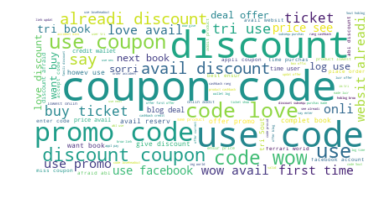

In [35]:
text = ' '.join(df_l.loc[(df_top.topic == 4) & (df_top.PTC > 30)].values)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

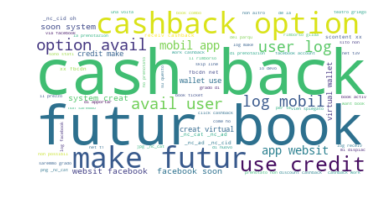

In [36]:
text = ' '.join(df_l.loc[(df_top.topic == 0) & (df_top.PTC > 30)].values)
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()